In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
from src.pmf import transient_distribution_piecewise
import os
import pickle
import numpy as np
from pathlib import Path
import abc
class RollingPredictor(abc.ABC):
    @abc.abstractmethod
    def rolling_prediction(self, times, values, verbose=True):
        pass
    @abc.abstractmethod
    def get_summary_metrics(self):
        pass
    @abc.abstractmethod
    def plot_rolling_predictions(self, original_times=None, original_values=None, 
                               show_confidence=True, show_errors=True):
        pass
class RollingKalmanPredictor(RollingPredictor):
    """
    Rolling Kalman Predictor
    
    For each time point t, use all historical data up to t to predict the value at t.
    """
    
    def __init__(self, min_history_length=5):
        """
        Initialize the rolling predictor
        
        Args:
            min_history_length: Minimum number of historical data points required for prediction
        """
        self.min_history_length = min_history_length
 
    def estimate_parameters_window(self, times, values,a,b):
        """
        Estimate model parameters from a given time window
        
        Use moment estimation for fast parameter estimation
        """
        dt = np.mean(np.diff(times)) if len(times) > 1 else 0.1
        
        # Long-term mean
        # b = np.mean(values)
        
        # Mean reversion speed (from lag-1 autocorrelation)
        # if len(values) > 2:
        #     values_array = np.array(values)
        #     corr = np.corrcoef(values_array[:-1], values_array[1:])[0, 1]
        #     phi = max(0.05, min(0.95, corr))
        #     a = max(0.01, (1 - phi) / dt)
        # else:
        #     a = 0.3
        
        # Volatility parameter
        if len(values) > 3:
            residuals = []
            for i in range(1, len(values)):
                predicted = values[i-1] + a * (b - values[i-1]) * dt
                residual = values[i] - predicted
                residuals.append(residual)
            
            if len(residuals) > 0:
                residual_var = np.var(residuals)
                sigma = np.sqrt(residual_var / (b * dt))
                sigma = max(0.1, min(3.0, sigma))
            else:
                sigma = 1.0
        else:
            sigma = 1.0
        
        return a, b, sigma, dt
    
    def kalman_one_step_prediction(self, times, values):
        """
        Use historical data for one-step prediction
        
        Args:
            times: Historical time series
            values: Historical observation sequence
            
        Returns:
            dict: Contains prediction value, uncertainty, etc.
        """
        if len(times) < 2:
            return None
        
        # Estimate model parameters (only using historical data)
        a,b= 0.3,80

        a, b, sigma, dt = self.estimate_parameters_window(times, values,a,b)
        # Initialize Kalman filter
        Z_current = values[0]
        P_current = 100.0
        
        # Update Kalman filter state using historical data
        for i in range(1, len(values)):
            # Prediction step
            Z_pred = Z_current + a * (b - Z_current) * dt
            F = 1 - a * dt
            Q = sigma**2 * max(0.1, Z_current) * dt
            P_pred = F * P_current * F + Q
            
            # Update step
            observation = values[i]
            H = 1.0
            R = max(1.0, 0.1 * abs(observation))
            S = H * P_pred * H + R
            K = P_pred * H / S
            
            innovation = observation - Z_pred
            Z_current = max(0.01, Z_pred + K * innovation)
            P_current = (1 - K * H) * P_pred
        
        # Next step prediction based on current state
        Z_next_pred = Z_current + a * (b - Z_current) * dt
        F = 1 - a * dt
        Q = sigma**2 * max(0.1, Z_current) * dt
        P_next_pred = F * P_current * F + Q
        
        # Calculate confidence interval
        std_pred = np.sqrt(P_next_pred)
        conf_lower = Z_next_pred - 1.96 * std_pred
        conf_upper = Z_next_pred + 1.96 * std_pred
        
        return {
            'prediction': Z_next_pred,
            'uncertainty': std_pred,
            'confidence_lower': conf_lower,
            'confidence_upper': conf_upper,
            'parameters': {'a': a, 'b': b, 'sigma': sigma, 'dt': dt}
        }
    
    def rolling_prediction(self, times, values, verbose=True):
        """
        Execute rolling prediction: for each time point, use previous data to predict the value at that point
        
        Args:
            times: Complete time series
            values: Complete observation sequence
            verbose: Whether to output detailed information
            
        Returns:
            dict: Summary of prediction results
        """
        # Validate input
        if len(times) != len(values):
            raise ValueError("times and values must have the same length")
        
        if len(times) < self.min_history_length + 1:
            raise ValueError(f"At least {self.min_history_length + 1} data points are required")
        
        # Ensure data is sorted by time
        sorted_indices = np.argsort(times)
        times = np.array(times)[sorted_indices]
        values = np.array(values)[sorted_indices]
        
        # Reset results
        self.results = {
            'prediction_times': [],
            'predictions': [],
            'actual_values': [],
            'prediction_errors': [],
            'confidence_lower': [],
            'confidence_upper': [],
            'model_parameters': [],
            'used_history_length': [],
            'predicted_step_function': [],
            'predicted_step_function_time_interval': []
        }
        
        if verbose:
            print("="*60)
            print("Rolling prediction")
            print("="*60)
            print(f"Total data points: {len(times)}")
            print(f"Prediction points: {len(times) - self.min_history_length}")
            print(f"Minimum history length: {self.min_history_length}")
        
        # For each time point, predict the value at that point (starting from the (min_history_length+1)th point)
        successful_predictions = 0
        self.results['predicted_step_function'] = [values[:self.min_history_length].mean()]
        self.results['predicted_step_function_time_interval'] = [times[self.min_history_length-1] - times[0]]
        last_current_time = times[self.min_history_length-1]
        for i in range(self.min_history_length, len(times)):
            # Use times[0:i] and values[0:i] to predict values[i]
            history_times = times[:i]
            history_values = values[:i]
            
            # Current time point and actual value to be predicted
            current_time = times[i]
            actual_value = values[i]
            
            # Perform prediction (only using historical data)
            pred_result = self.kalman_one_step_prediction(history_times, history_values)
            
            if pred_result is not None:
                prediction = pred_result['prediction']
                conf_lower = pred_result['confidence_lower']
                conf_upper = pred_result['confidence_upper']
                params = pred_result['parameters']
                
                # Store results
                # if len(self.results['prediction_times']) == 1 or current_time != self.results['prediction_times'][-1]:
                self.results['prediction_times'].append(current_time)
                self.results['stepwise_value'].append(prediction)
                self.results['predicted_step_function_time_interval'].append(current_time -last_current_time)
                last_current_time = current_time
                
                self.results['predictions'].append(prediction)
                self.results['actual_values'].append(actual_value)
                self.results['prediction_errors'].append(actual_value - prediction)
                self.results['confidence_lower'].append(conf_lower)
                self.results['confidence_upper'].append(conf_upper)
                self.results['model_parameters'].append(params)
                self.results['used_history_length'].append(len(history_times))
                
                successful_predictions += 1
                
                if verbose and i < self.min_history_length + 5:
                    print(f"Time {current_time:.3f}: Predicted={prediction:.2f}, Actual={actual_value:.2f}, "
                          f"Error={actual_value - prediction:.2f}")
        
        if verbose:
            print(f"Successfully predicted: {successful_predictions} points")
        
        return self.get_summary_metrics()
    
    def get_summary_metrics(self):
        """
        Calculate prediction performance metrics
        """
        if len(self.results['predictions']) == 0:
            return None
        
        predictions = np.array(self.results['predictions'])
        actuals = np.array(self.results['actual_values'])
        errors = np.array(self.results['prediction_errors'])
        
        # Calculate various metrics
        mse = np.mean(errors**2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(errors))
        mape = np.mean(np.abs(errors / actuals)) * 100
        
        # Direction accuracy (whether the predicted trend is correct)
        if len(actuals) > 1:
            actual_directions = np.sign(np.diff(actuals))
            pred_directions = np.sign(np.diff(predictions))
            direction_accuracy = np.mean(actual_directions == pred_directions) * 100
        else:
            direction_accuracy = 0
        
        # Confidence interval coverage
        lower_bounds = np.array(self.results['confidence_lower'])
        upper_bounds = np.array(self.results['confidence_upper'])
        coverage = np.mean((actuals >= lower_bounds) & (actuals <= upper_bounds)) * 100
        
        return {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'direction_accuracy': direction_accuracy,
            'confidence_coverage': coverage,
            'n_predictions': len(predictions),
            'mean_prediction': np.mean(predictions),
            'mean_actual': np.mean(actuals)
        }
    
    def plot_rolling_predictions(self, original_times=None, original_values=None, 
                               show_confidence=True, show_errors=True):
        """
        Plot rolling prediction results
        
        Args:
            original_times: Original complete time series (for context)
            original_values: Original complete observation sequence
            show_confidence: Whether to show confidence interval
            show_errors: Whether to show error plot
        """
        if len(self.results['predictions']) == 0:
            print("No prediction results to plot")
            return
        
        n_plots = 2 if show_errors else 1
        fig, axes = plt.subplots(n_plots, 1, figsize=(15, 6*n_plots))
        if n_plots == 1:
            axes = [axes]
        
        # Main plot: Predicted vs Actual
        ax1 = axes[0]
        
        # If original data is provided, plot the complete observation sequence as background
        if original_times is not None and original_values is not None:
            ax1.plot(original_times, original_values, 'lightgray', alpha=0.5, 
                    linewidth=1, label='Complete observation sequence')
        
        # Prediction and actual points
        pred_times = self.results['prediction_times']
        predictions = self.results['predictions']
        actual_values = self.results['actual_values']
        # Use line plots instead of scatter plots for actual and predicted values
        ax1.plot(pred_times, actual_values, color='blue', alpha=0.7, linewidth=2, 
                 label='Actual values', zorder=3, marker='o')
        ax1.plot(pred_times, predictions, color='red', alpha=0.8, linewidth=2, 
                 label='Predicted values', zorder=3, marker='^')
        
        # Connecting lines to show the relationship between predicted and actual values
        for i in range(len(pred_times)):
            ax1.plot([pred_times[i], pred_times[i]], 
                    [actual_values[i], predictions[i]], 
                    'gray', alpha=0.3, linewidth=1, zorder=1)
        
        # Confidence interval
        if show_confidence:
            conf_lower = self.results['confidence_lower']
            conf_upper = self.results['confidence_upper']
            ax1.fill_between(pred_times, conf_lower, conf_upper, 
                           alpha=0.2, color='red', label='95% Confidence interval')
        
        ax1.set_ylabel('Intensity value Z_t')
        ax1.set_title('Rolling prediction result: predict each time point using historical data')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Add performance metrics text
        metrics = self.get_summary_metrics()
        if metrics:
            metrics_text = (f'RMSE: {metrics["rmse"]:.3f}\n'
                           f'MAE: {metrics["mae"]:.3f}\n'
                           f'Direction accuracy: {metrics["direction_accuracy"]:.1f}%\n'
                           f'Confidence coverage: {metrics["confidence_coverage"]:.1f}%')
            ax1.text(0.02, 0.98, metrics_text, transform=ax1.transAxes, 
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))
        
        # Error plot
        if show_errors:
            ax2 = axes[1]
            errors = self.results['prediction_errors']
            
            ax2.scatter(pred_times, errors, color='purple', alpha=0.6, s=20)
            ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            
            # Error statistics line
            error_mean = np.mean(errors)
            error_std = np.std(errors)
            ax2.axhline(y=error_mean, color='red', linestyle='-', alpha=0.7, 
                       label=f'Average error: {error_mean:.3f}')
            ax2.axhline(y=error_mean + 2*error_std, color='red', linestyle=':', 
                       alpha=0.7, label='±2 Std')
            ax2.axhline(y=error_mean - 2*error_std, color='red', linestyle=':', alpha=0.7)
            
            ax2.set_ylabel('Prediction error (Actual - Predicted)')
            ax2.set_xlabel('Time')
            ax2.set_title('Prediction error analysis')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def get_prediction_at_time(self, target_time):
        """
        Get prediction results at a specific time point
        """
        for i, time in enumerate(self.results['prediction_times']):
            if abs(time - target_time) < 1e-6:
                return {
                    'time': time,
                    'prediction': self.results['predictions'][i],
                    'actual': self.results['actual_values'][i],
                    'error': self.results['prediction_errors'][i],
                    'confidence_lower': self.results['confidence_lower'][i],
                    'confidence_upper': self.results['confidence_upper'][i],
                    'history_length': self.results['used_history_length'][i]
                }
        return None


    

In [22]:
  
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import rbf_kernel
import statsmodels.api as sm

class OLScpdPredictor():
    def __init__(self, min_history_length=5):
        self.results = {
            # 'prediction_times': [],
            'predicted_value': [],
            'value': [],
            'prediction_errors': [],
            # 'confidence_lower': [],
            # 'confidence_upper': [],
            # 'model_parameters': [],
            # 'used_history_length': [],
            'stepwise_value': [],
            'predicted_step_function_time_interval': []
        }
        
        pass
    def mmd_statistic(self,x, y, gamma=None):
        """
        Compute the Maximum Mean Discrepancy (MMD) between two samples.
        
        Parameters:
        -----------
        x : array-like
            First sample
        y : array-like
            Second sample
        gamma : float
            RBF kernel bandwidth parameter
            
        Returns:
        --------
        float
            MMD statistic value
        """
        x = np.array(x).reshape(-1, 1)
        y = np.array(y).reshape(-1, 1)
        
        # Compute kernel matrices
        k_xx = rbf_kernel(x, x, gamma)
        k_yy = rbf_kernel(y, y, gamma)
        k_xy = rbf_kernel(x, y, gamma)
        
        # Compute MMD
        n = len(x)
        m = len(y)
        
        mmd = (np.sum(k_xx) - np.trace(k_xx)) / (n * (n - 1))
        mmd += (np.sum(k_yy) - np.trace(k_yy)) / (m * (m - 1))
        mmd -= 2 * np.sum(k_xy) / (n * m)
        
        return mmd

    def rolling_prediction(self,data, window_size=3, gamma=None, plot=True, method='ols',file_name=None):
        """
        Analyze deviations between predicted model values and actual data using Maximum Mean Discrepancy (MMD).
        
        Parameters:
        -----------
        data : pandas.DataFrame
            DataFrame containing 'value' and 'time' columns.
        window_size : int, optional (default=3)
            Size of sliding window for analysis.
        gamma : float, optional (default=None)
            RBF kernel bandwidth parameter. If None, calculated using median heuristic.
        plot : bool, optional (default=True)
            Whether to plot the results.
        method : str, optional (default='ols')
            'ols' for standard linear regression on time, 'diff_ols' for the mean-reverting model.
            
        Returns:
        --------
        pandas.DataFrame
            DataFrame with original data, predicted values, and deviation points detected.
        list
            List of detected significant deviation indices.
        """
        data = data.copy()

        if 'time' not in data.columns:
            data['time'] = np.arange(len(data))
        
        if 'predicted_value' not in data.columns:
            data['predicted_value'] = np.nan

        all_deviation_points = []
        
        if len(data) < 2 * window_size:
            print(f"Warning: Data length ({len(data)}) is less than 2*window_size ({2*window_size})")
            return data, all_deviation_points, np.nan

        detect_window_size = int(window_size * 1)
        predict_window_size = 2 * window_size - detect_window_size

        def fit_diff_ols(df_window):
            if len(df_window) < 2:
                return None
            
            delta_t = df_window['time'].diff().mean()
            if pd.isna(delta_t) or delta_t == 0:
                delta_t = 1.0
                
            y_series = df_window['value'].diff() / delta_t
            x_series = df_window['value'].shift(1)
            
            temp_df = pd.DataFrame({'y': y_series, 'x': x_series}).dropna()

            if len(temp_df) < 2:
                return None
                
            Y = temp_df['y']
            X = sm.add_constant(temp_df['x'])
            
            return sm.OLS(Y, X).fit()

        # --- Initial Model Training ---
        initial_window = data.iloc[:window_size]
        if method == 'ols':
            X_init = sm.add_constant(initial_window['time'])
            Y_init = initial_window['value']
            results = sm.OLS(Y_init, X_init).fit()
        elif method == 'diff_ols':
            results = fit_diff_ols(initial_window)
            if results is None:
                print("Could not initialize diff_ols model due to insufficient data.")
                return data, [], np.nan
        
        # --- Prediction and Detection Loop ---
        for i in range(2 * window_size, len(data) + 1, window_size):
            predict_start_idx = i - window_size
            predict_end_idx = predict_start_idx + predict_window_size
            predict_indices = data.index[predict_start_idx:predict_end_idx]
            
            # --- Windowed Prediction ---
            if method == 'ols':
                X_predict = sm.add_constant(data.loc[predict_indices, 'time'])
                data.loc[predict_indices, 'predicted_value'] = results.predict(X_predict)
            elif method == 'diff_ols':
                beta_0, beta_1 = results.params
                a = -beta_1
                b = -beta_0 / beta_1 if abs(beta_1) > 1e-6 else np.mean(data['value'].iloc[:i-window_size])
                
                z0_idx = predict_start_idx - 1 if predict_start_idx > 0 else 0
                z0 = data['value'].iloc[z0_idx]
                t0 = data['time'].iloc[z0_idx]
                time_diffs = data.loc[predict_indices, 'time'] - t0
                predicted_values = b + (z0 - b) * np.exp(- a * time_diffs)
                
                # Set an upper limit for predicted values
                upper_limit = np.max(data['value'].iloc[:i-window_size])  # You can adjust this logic as needed
                predicted_values = np.minimum(predicted_values, upper_limit)
                lower_limit = np.min(data['value'].iloc[:i-window_size])
                predicted_values = np.maximum(predicted_values, lower_limit)
                data.loc[predict_indices, 'predicted_value'] = predicted_values
            data.loc[predict_indices, 'stepwise_value'] = data.loc[predict_indices, 'predicted_value'].mean()
            
            # --- Distributional Comparison with MMD ---
            detect_indices = data.index[i - window_size : i - window_size + detect_window_size]
            # if method == 'ols':
            #     if gamma is None:
            #         # Use median heuristic for kernel bandwidth
            #         X_vals = np.vstack([
            #             data.iloc[i-window_size:i-window_size+detect_window_size]['value'].values.reshape(-1, 1), 
            #             data.iloc[i-window_size:i-window_size+detect_window_size]['predicted_value'].values.reshape(-1, 1)
            #         ])
            #         dists = rbf_kernel(X_vals, X_vals)
            #         gamma_val = 1.0 / np.median(dists[dists > 0])
            #     else:
            #         gamma_val = gamma
            # --- MMD Calculation ---
            mmd = self.mmd_statistic(data.loc[detect_indices, 'value'], data.loc[detect_indices, 'predicted_value'])
            threshold = 0.01
            # --- Deviation Detection & Model Adaptation ---
            if mmd > threshold:
                all_deviation_points.append(i - window_size)
                # --- Model Adaptation upon Deviation ---
                refit_window = data.iloc[i - window_size : i - window_size + detect_window_size]
                if method == 'ols':
                    X_refit = sm.add_constant(refit_window['time'])
                    Y_refit = refit_window['value']
                    results = sm.OLS(Y_refit, X_refit).fit()
                elif method == 'diff_ols':
                    new_results = fit_diff_ols(refit_window)
                    if new_results:
                        results = new_results
            else:
                # --- Continuous Learning (No Deviation) ---
                last_dev_idx = all_deviation_points[-1] if all_deviation_points else 0
                refit_window = data.iloc[last_dev_idx:i]
                if method == 'ols':
                    X_refit = sm.add_constant(refit_window['time'])
                    Y_refit = refit_window['value']
                    results = sm.OLS(Y_refit, X_refit).fit()
                elif method == 'diff_ols':
                    new_results = fit_diff_ols(refit_window)
                    if new_results:
                        results = new_results

        # --- Initial Data Handling ---
        data.loc[data.index[:window_size], 'stepwise_value'] = data.loc[data.index[:window_size], 'value'].mean()
        data.loc[data.index[:window_size], 'predicted_value'] = data.loc[data.index[:window_size], 'value'].mean()

        # --- Plotting and Final Metrics ---

        # Plot the results if requested
        if plot and len(data) > 0:
            plt.figure(figsize=(12, 7))
            plt.plot(data['time'], data['value'], label='Original Data', color='blue')
            plt.plot(data['time'], data['predicted_value'], label='Predicted Values', 
                    color='green', linestyle='--', alpha=0.8)
            # Plot stepwise function as a line instead of scatter points for better visualization
            plt.step(data['time'], data['stepwise_value'], label='Stepwise Function', color='orange', where='post', linewidth=2)
            # if all_deviation_points:
            #     deviation_point_indices = [data.index.get_loc(dp) for dp in all_deviation_points 
            #                               if dp in data.index]
            #     plt.scatter(data.iloc[deviation_point_indices]['index'], 
            #                data.iloc[deviation_point_indices]['value'], 
            #                color='red', s=100, marker='o', label='Significant Deviations')
                
            #     for idx in deviation_point_indices:
            #         plt.axvline(x=data.iloc[idx]['index'], color='red', 
            #                    linestyle=':', alpha=0.5)
                    
            plt.xlim(0, data['time'].iloc[-1])
            plt.title(f'Time Series with Detected Prediction Deviations, file_name={file_name},method={method}')
            plt.xlabel('Time')
            plt.ylabel('Value')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

        self.results['prediction_times'] = data['time']
        self.results['predictions'] = data['predicted_value']
        self.results['actual_values'] = data['value']
        self.results['prediction_errors'] = data['predicted_value'] - data['value']
        self.results['predicted_step_function'] = data['stepwise_value']
        self.results['predicted_step_function_time_interval'] = data['time']-data['time'].shift(1)
        self.results['predicted_step_function_time_interval'].iloc[0] = data['time'].iloc[0]
        # self.results['confidence_lower'] = data['predicted_value'] - 1.96 * np.sqrt(data['prediction_errors']**2)
        # self.results['confidence_upper'] = data['predicted_value'] + 1.96 * np.sqrt(data['prediction_errors']**2)
        # self.results['model_parameters'] = results.params
        return self.get_summary_metrics()
    
    def get_summary_metrics(self):
        """
        Calculate prediction performance metrics
        """
        if len(self.results['predictions']) == 0:
            return None
        if 'prediction_errors' not in self.results:
            self.results['prediction_errors'] = self.results['predictions'] - self.results['actual_values']
        if 'confidence_lower' not in self.results:
            self.results['confidence_lower'] = self.results['predictions'] - 1.96 * np.sqrt(self.results['prediction_errors']**2)
        if 'confidence_upper' not in self.results:
            self.results['confidence_upper'] = self.results['predictions'] + 1.96 * np.sqrt(self.results['prediction_errors']**2)
        predictions = np.array(self.results['predictions'])
        actuals = np.array(self.results['actual_values'])
        errors = np.array(self.results['prediction_errors'])
        
        # Calculate various metrics
        mse = np.mean(errors**2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(errors))
        mape = np.mean(np.abs(errors / actuals)) * 100
        
        # Direction accuracy (whether the predicted trend is correct)
        if len(actuals) > 1:
            actual_directions = np.sign(np.diff(actuals))
            pred_directions = np.sign(np.diff(predictions))
            direction_accuracy = np.mean(actual_directions == pred_directions) * 100
        else:
            direction_accuracy = 0
        
        # Confidence interval coverage
        lower_bounds = np.array(self.results['confidence_lower'])
        upper_bounds = np.array(self.results['confidence_upper'])
        coverage = np.mean((actuals >= lower_bounds) & (actuals <= upper_bounds)) * 100
        
        return {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'direction_accuracy': direction_accuracy,
            'confidence_coverage': coverage,
            'n_predictions': len(predictions),
            'mean_prediction': np.mean(predictions),
            'mean_actual': np.mean(actuals)
        }
    



In [23]:

    
from typing import ValuesView


def rolling_predictor(times, values, min_history_length=5, verbose=True,method='cpd'):
    """
    Main function: rolling Kalman filter prediction
    
    For each time point t (starting from the (min_history_length+1)th point), use historical data up to t to predict the value at t.
    
    Args:
        times: Time series
        values: Observation sequence  
        min_history_length: Minimum number of historical data points required for prediction
        verbose: Whether to display detailed information
        
    Returns:
        dict: Contains all prediction results and performance metrics
    """

    if method == 'kalman':
        predictor = RollingKalmanPredictor(min_history_length=min_history_length)
        summary_metrics = predictor.rolling_prediction(times, values, verbose=verbose)
        predictor.plot_rolling_predictions(original_times=times, original_values=values)

    elif method == 'cpd':
        predictor = OLScpdPredictor(min_history_length=min_history_length)
        df = pd.DataFrame({'time': times, 'value': values})
        summary_metrics = predictor.rolling_prediction(df,window_size=3, gamma=None, plot=True, method='ols',file_name=None)
    
    if verbose and summary_metrics:
        print("\n" + "="*60)
        print("Prediction performance summary")
        print("="*60)
        print(f"Root mean square error (RMSE): {summary_metrics['rmse']:.4f}")
        print(f"Mean absolute error (MAE): {summary_metrics['mae']:.4f}")
        print(f"Mean absolute percentage error (MAPE): {summary_metrics['mape']:.2f}%")
        print(f"Direction prediction accuracy: {summary_metrics['direction_accuracy']:.1f}%")
        print(f"95% confidence interval coverage: {summary_metrics['confidence_coverage']:.1f}%")
        print(f"Successfully predicted points: {summary_metrics['n_predictions']}")
        print("="*60)
    
    
    
    return {
        'predictor': predictor,
        'summary_metrics': summary_metrics,
        'detailed_results': predictor.results
    }
    
def plot_pmf_overlap(window_sizes, t, file_path, save_path, Z_piece, dt_piece, mu, m,
                    z_initial=80, hist_data_path=None, N=100, show_histogram=True):
    """
    Plot PMFs for different window sizes overlapped with simulation histogram.
    
    Args:
        window_sizes: List of window sizes to compare
        t: Time point for PMF calculation
        file_path: Source file path for reference (not used in current implementation)
        save_path: Directory to save the plot
        Z_piece: Predicted step function values
        dt_piece: Time intervals for step function
        mu: Model parameter mu (service rate)
        m: Model parameter m
        z_initial: Initial queue length (used for histogram file naming)
        hist_data_path: Path to histogram data directory
        N: Maximum number of states for PMF calculation
        show_histogram: Whether to overlay simulation histogram
    """

    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Define colors for theory curves
    theory_colors = ['red', 'darkgreen', 'orange', 'purple', 'brown']
    
    probabilities = None
    x_hist = None
    kl_data=[]
    if show_histogram and hist_data_path:
        try:
            service_rate = 10 if z_initial == 5 else 100 if z_initial == 80 else mu
            hist_filename = f"for_histogram_CoxM1_Z0{z_initial}_serv{service_rate}_t{int(t)}.pickle"
            hist_path = os.path.join(hist_data_path, hist_filename)
            
            with open(hist_path, 'rb') as f:
                hist_data = pickle.load(f)
            
            counts = hist_data['counts']
            bins = hist_data['bins']
            
            # Handle bins that don't start at 0
            if bins[0] != 0:
                bins = np.array(bins, dtype=int)
                interval = max(int(bins[1] - bins[0]), 1)
                bins_before = np.arange(0, bins[0], interval)
                bins = np.concatenate([bins_before, bins])
                counts_before = np.zeros(len(bins_before))
                counts = np.concatenate([counts_before, counts])
            # Normalize counts to probabilities
            total_count = np.sum(counts)
            if total_count > 0:
                probabilities = counts / total_count
                x_hist = bins[:-1]  # Use bin starts for x coordinates
                
                # Plot histogram
                ax.bar(x_hist, probabilities,
                      width=bins[1] - bins[0] if len(bins) > 1 else 1,
                      alpha=0.4,
                      color='lightblue',
                      label=f'Simulation t={int(t)}',
                      zorder=1)
                print(f"✓ Loaded histogram: {hist_filename}")
                print(f"  Total count: {total_count}")
                print(f"  Probability sum: {np.sum(probabilities):.6f}")
                print(f"  Histogram range: [{probabilities.min():.6f}, {probabilities.max():.6f}]")
                print(f"  Bins range: [{bins[0]}, {bins[-1]}]")
            else:
                print(f"Warning: Empty histogram for {hist_filename}")
                
        except FileNotFoundError:
            print(f"Warning: Histogram file not found: {hist_path}")
        except Exception as e:
            print(f"Error loading histogram: {e}")
            import traceback
            traceback.print_exc()
    
    plotted_theory_curves = 0
    
    for idx, ws in enumerate(window_sizes):
        try:
            # Calculate PMF
            pt = transient_distribution_piecewise(Z_piece, dt_piece, mu, m, t=t, N=N)
            # Ensure we have valid PMF data
            if pt is None or len(pt) == 0:
                print(f"Warning: Empty PMF for window size {ws}")
                continue
            
            # Create x values for plotting - starting from 0
            x_vals = np.arange(len(pt))
            
            # If we need to clip to match histogram bins, do it here
            if x_hist is not None:
                # Clip to the same range as histogram for better visualization
                max_x = min(len(x_hist), len(pt))
                x_vals = x_vals[:max_x]
                y_vals = pt[:max_x]
            else:
                y_vals = pt
            
            # Determine color
            color = theory_colors[idx] if idx < len(theory_colors) else f'C{idx}'
            
            # Plot PMF curve
            ax.plot(x_vals, y_vals,
                   marker='o',
                   linestyle='-',
                   color=color,
                   label=f'Theory WS={ws}',
                   linewidth=2,
                   markersize=4,
                   zorder=2)
            
            print(f"✓ Plotted PMF for window size {ws}")
            print(f"  PMF sum: {np.sum(pt):.6f}")
            print(f"  Plotted PMF sum: {np.sum(y_vals):.6f}")
            print(f"  PMF range: [{np.min(y_vals):.6f}, {np.max(y_vals):.6f}]")
            print(f"  PMF length: {len(pt)}, Plotted length: {len(y_vals)}")
            
            plotted_theory_curves += 1
            kl_data.append(compare_pmfs_kl(probabilities, y_vals, labels=("Simulation", "Prediction"), plot=True))
 
        except Exception as e:
            print(f"Error calculating PMF for window size {ws}: {e}")
            import traceback
            traceback.print_exc()

    # Configure plot appearance
    if plotted_theory_curves == 0:
        print("Warning: No theory curves were plotted")
    
    # Set plot properties
    ax.set_title(f'Queue Length Distribution: Cox/M/1\n'
                f't={int(t)}, Z₀={z_initial}, μ={mu}',
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Queue Length (Number of Customers)', fontsize=12)
    ax.set_ylabel('Probability', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    
    # Set axis limits intelligently
    if x_hist is not None and probabilities is not None and len(probabilities) > 0:
        # Find meaningful range based on histogram data
        max_prob = np.max(probabilities)
        meaningful_indices = np.where(probabilities > max_prob * 0.01)[0]
        if len(meaningful_indices) > 0:
            # Use the actual x values from histogram
            x_max = min(x_hist[meaningful_indices[-1]] + 5, max(x_hist[-1], N))
        else:
            x_max = min(40, N)
    else:
        x_max = min(40, N)
    
    ax.set_xlim(0, x_max)
    ax.set_ylim(bottom=0)
    
    # Auto-adjust y-axis to show the data better
    y_data = []
    if probabilities is not None:
        y_data.extend(probabilities)
    for i in range(plotted_theory_curves):
        # Get the theory curve data from the plot
        lines = ax.get_lines()
        if i < len(lines):
            y_data.extend(lines[i].get_ydata())
    
    if y_data:
        max_y = max(y_data) * 1.1  # Add 10% padding
        ax.set_ylim(0, max_y)
    
    # Ensure save directory exists and save plot
    save_dir = Path(save_path)
    save_dir.mkdir(parents=True, exist_ok=True)
    
    filename = f"pmf_overlap_t{int(t)}.png"
    full_path = save_dir / filename
    
    plt.tight_layout()
    plt.savefig(full_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ PMF overlap plot saved to {full_path}")
    print("-" * 50)


def calculate_kl_divergence(p: np.ndarray, q: np.ndarray, epsilon: float = 1e-10) -> float:
    """
    Calculate KL divergence KL(P||Q) between two probability distributions.
    
    KL(P||Q) = sum(p_i * log(p_i / q_i))
    
    Args:
        p: True/reference distribution (must sum to 1)
        q: Approximating distribution (must sum to 1)
        epsilon: Small value to avoid log(0) and division by zero
        
    Returns:
        KL divergence value (always >= 0)
    """
    # Ensure inputs are numpy arrays
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    
    # Normalize to ensure they sum to 1
    p = p / np.sum(p)
    q = q / np.sum(q)
    
    # Make distributions the same length by padding with zeros
    max_len = max(len(p), len(q))
    if len(p) < max_len:
        p = np.pad(p, (0, max_len - len(p)), mode='constant', constant_values=0)
    if len(q) < max_len:
        q = np.pad(q, (0, max_len - len(q)), mode='constant', constant_values=0)
    
    # Add epsilon to avoid numerical issues
    p = p + epsilon
    q = q + epsilon
    
    # Renormalize after adding epsilon
    p = p / np.sum(p)
    q = q / np.sum(q)
    
    # Calculate KL divergence
    kl_div = np.sum(p * np.log(p / q))
    
    return kl_div


def compare_pmfs_kl(pmf1: [np.ndarray, list], 
                    pmf2: [np.ndarray, list],
                    labels:[str, str] = ("PMF1", "PMF2"),
                    plot: bool = True):
    """
    Compare two PMFs using KL divergence and optionally visualize them.
    
    Args:
        pmf1: First probability mass function
        pmf2: Second probability mass function
        labels: Labels for the two PMFs
        plot: Whether to plot the PMFs for comparison
        
    Returns:
        Dictionary containing KL divergences and statistics
    """
    import matplotlib.pyplot as plt
    
    # Convert to numpy arrays
    pmf1 = np.asarray(pmf1, dtype=float)
    pmf2 = np.asarray(pmf2, dtype=float)
    
    # Normalize
    pmf1 = pmf1 / np.sum(pmf1)
    pmf2 = pmf2 / np.sum(pmf2)
    
    # Calculate both directions of KL divergence
    kl_1_to_2 = calculate_kl_divergence(pmf1, pmf2)
    kl_2_to_1 = calculate_kl_divergence(pmf2, pmf1)
    
    # Calculate symmetric KL (average of both directions)
    kl_symmetric = (kl_1_to_2 + kl_2_to_1) / 2
    
    # Calculate Jensen-Shannon divergence (symmetric and bounded)
    m = (pmf1 + pmf2) / 2
    js_divergence = (calculate_kl_divergence(pmf1, m) + calculate_kl_divergence(pmf2, m)) / 2
    
    results = {
        f'KL({labels[0]}||{labels[1]})': kl_1_to_2,
        f'KL({labels[1]}||{labels[0]})': kl_2_to_1,
        'KL_symmetric': kl_symmetric,
        'JS_divergence': js_divergence,
        'pmf1_entropy': -np.sum(pmf1 * np.log(pmf1 + 1e-10)),
        'pmf2_entropy': -np.sum(pmf2 * np.log(pmf2 + 1e-10))
    }
    
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Plot PMFs
        ax1 = axes[0]
        x1 = np.arange(len(pmf1))
        x2 = np.arange(len(pmf2))
        
        ax1.plot(x1, pmf1, 'b-o', label=labels[0], alpha=0.7, markersize=4)
        ax1.plot(x2, pmf2, 'r-s', label=labels[1], alpha=0.7, markersize=4)
        ax1.set_xlabel('State')
        ax1.set_ylabel('Probability')
        ax1.set_title('PMF Comparison')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot log-scale for better visibility of tail
        ax2 = axes[1]
        # Only plot non-zero values on log scale
        pmf1_nonzero = pmf1[pmf1 > 0]
        pmf2_nonzero = pmf2[pmf2 > 0]
        x1_nonzero = x1[pmf1 > 0]
        x2_nonzero = x2[pmf2 > 0]
        
        ax2.semilogy(x1_nonzero, pmf1_nonzero, 'b-o', label=labels[0], alpha=0.7, markersize=4)
        ax2.semilogy(x2_nonzero, pmf2_nonzero, 'r-s', label=labels[1], alpha=0.7, markersize=4)
        ax2.set_xlabel('State')
        ax2.set_ylabel('Probability (log scale)')
        ax2.set_title('PMF Comparison (Log Scale)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Add KL divergence info to plot
        info_text = (f'KL({labels[0]}||{labels[1]}) = {kl_1_to_2:.4f}\n'
                    f'KL({labels[1]}||{labels[0]}) = {kl_2_to_1:.4f}\n'
                    f'Symmetric KL = {kl_symmetric:.4f}\n'
                    f'JS Divergence = {js_divergence:.4f}')
        
        fig.text(0.5, 0.02, info_text, ha='center', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        plt.show()
    
    return results


Predictor


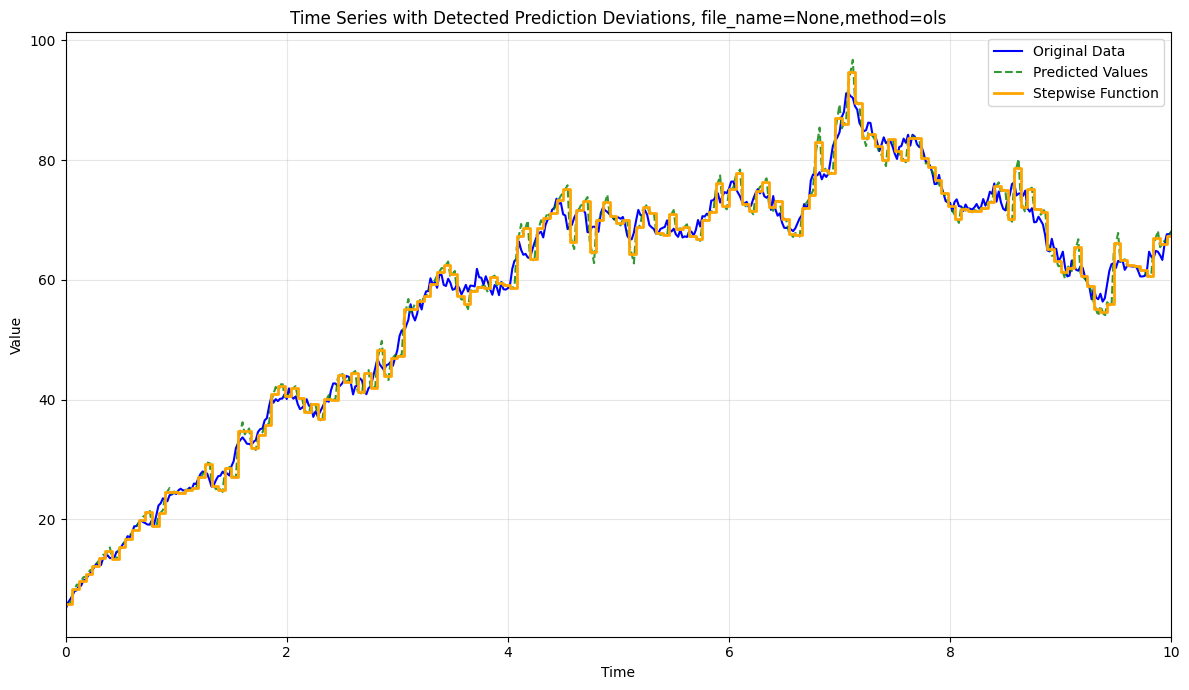


Prediction performance summary
Root mean square error (RMSE): 2.0924
Mean absolute error (MAE): 1.5888
Mean absolute percentage error (MAPE): 3.06%
Direction prediction accuracy: 55.8%
95% confidence interval coverage: 100.0%
Successfully predicted points: 501

Usage:
result = rolling_kalman_predictor(data['time'], data['value'])
All prediction results in: result['detailed_results']

Printing PMF overlap:
(501,) (501,)
✓ Loaded histogram: for_histogram_CoxM1_Z05_serv10_t5.pickle
  Total count: 1.444444444444439
  Probability sum: 1.000000
  Histogram range: [0.000000, 0.025004]
  Bins range: [0, 260]
✓ Plotted PMF for window size 10
  PMF sum: 1.000000
  Plotted PMF sum: 1.000000
  PMF range: [0.000000, 0.024854]
  PMF length: 351, Plotted length: 340


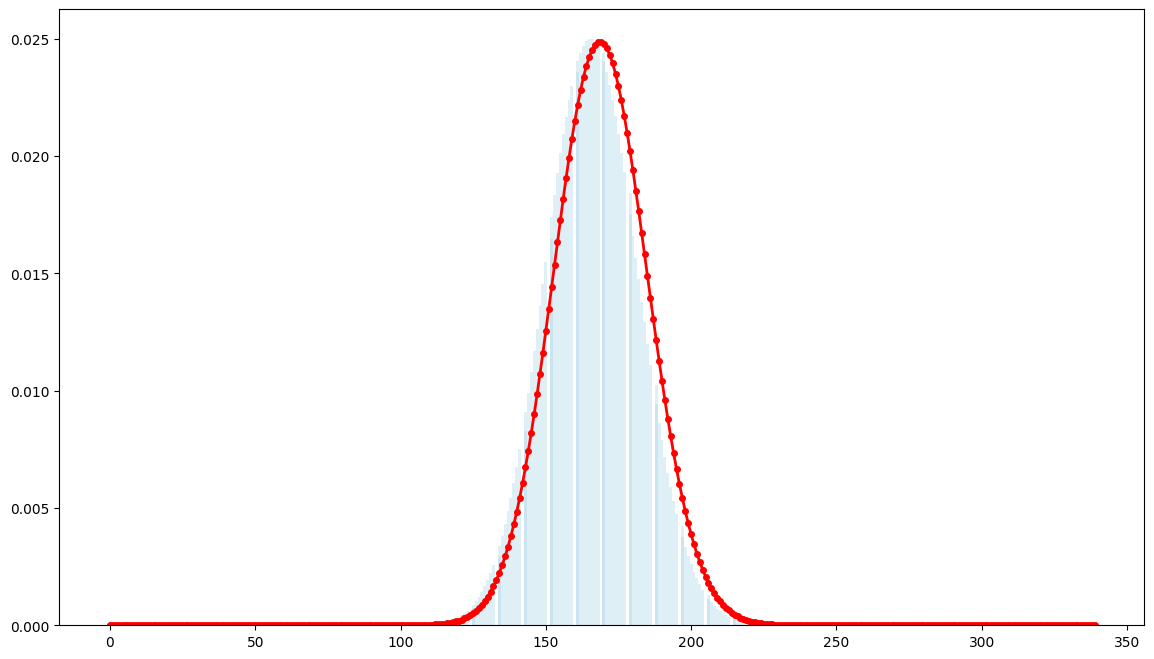

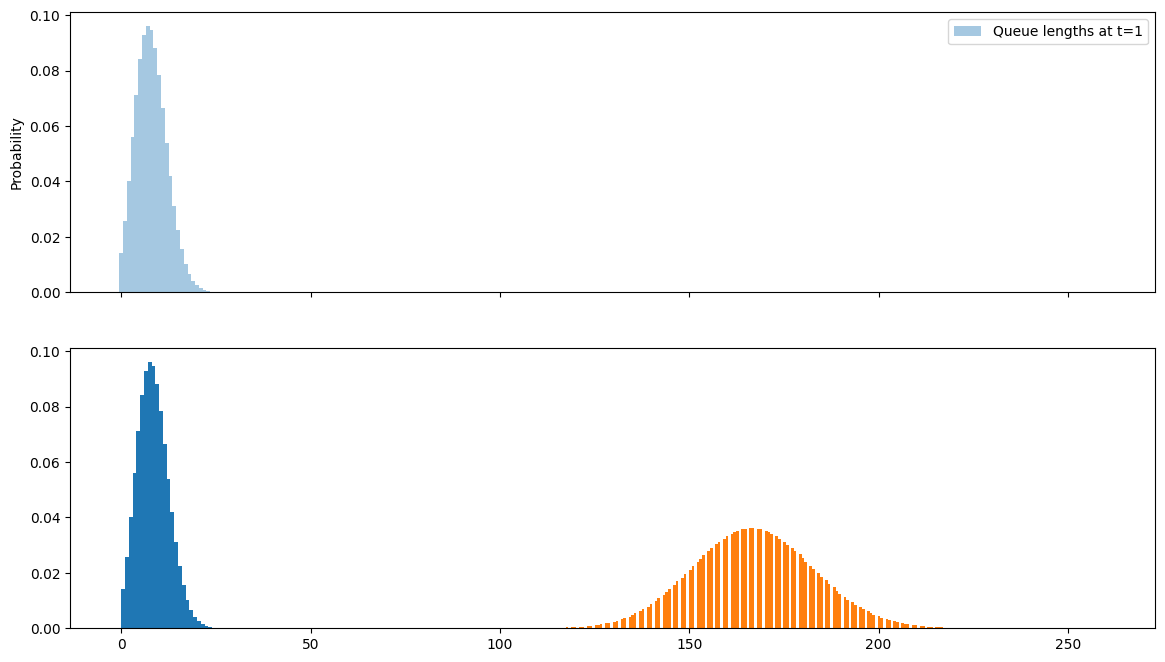

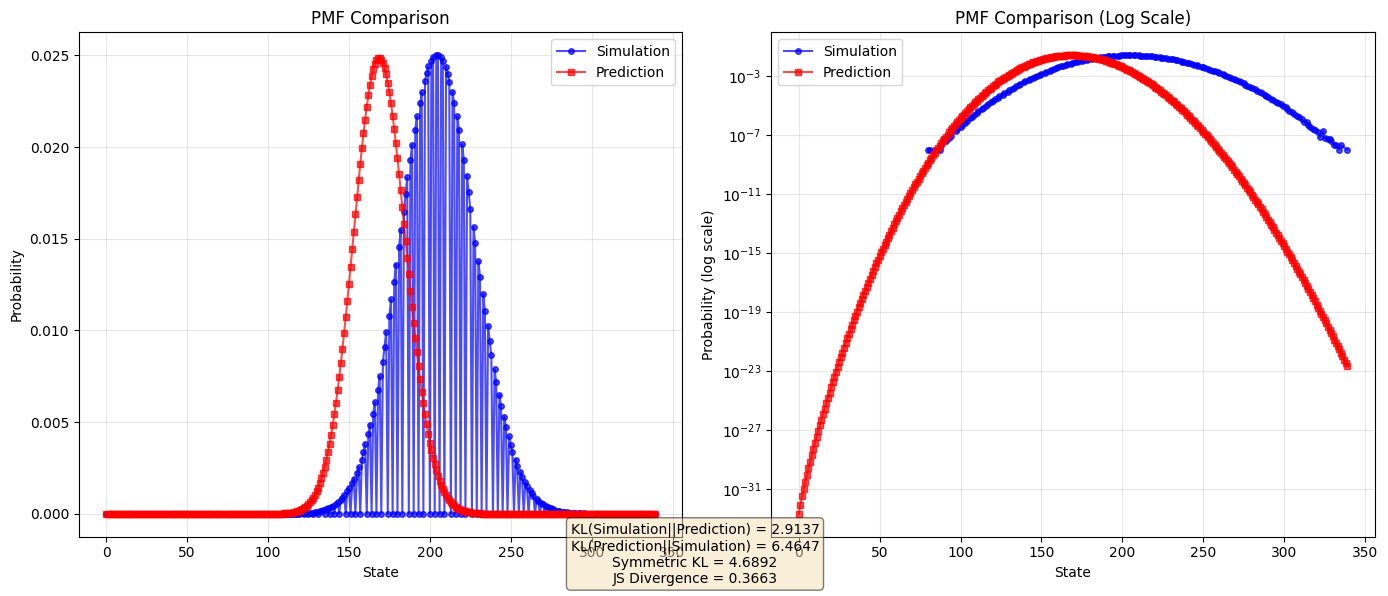

<Figure size 640x480 with 0 Axes>

✅ PMF overlap plot saved to /home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/pmf_data/M=500/initial_value_5_samples_500_predicted_cpd_pmf_min_hist_length_10/pmf_overlap_t5.png
--------------------------------------------------


In [24]:
if __name__ == "__main__":
    np.random.seed(42)
    z_initial=5
    min_history_length=10
    method='cpd'
    values = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['value']
    times = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['time']
    
    print("Predictor")
 
    # Execute rolling prediction

    result = rolling_predictor(times, values, min_history_length=min_history_length, verbose=True,method=method)
    file_path_prediction = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/result_data/initial_value_{z_initial}_samples_500_predicted_{method}_min_history_length_{min_history_length}.csv'
    pd.DataFrame(result).to_csv(file_path_prediction)
    
    print(f"\nUsage:")
    print(f"result = rolling_kalman_predictor(data['time'], data['value'])")
    print(f"All prediction results in: result['detailed_results']")
    
    print('\nPrinting PMF overlap:')
    file_path_pmf = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/pmf_data/M=500/initial_value_{z_initial}_samples_500_predicted_{method}_pmf_min_hist_length_{min_history_length}/'   

    print((result['detailed_results']['predicted_step_function_time_interval'].shape),(result['detailed_results']['predicted_step_function'].shape))
    plot_pmf_overlap(
        [min_history_length],
        t=5,
        file_path=file_path_prediction,  # changed from 'file' to 'file_path'
        save_path=file_path_pmf,
        Z_piece=result['detailed_results']['predicted_step_function'],
        dt_piece=result['detailed_results']['predicted_step_function_time_interval'],
        mu=10 if z_initial == 5 else 100 if z_initial == 80 else 100,
        m=1,
        z_initial=z_initial,
        hist_data_path='/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/Simulation_histograms',
        N=350, # max number of states
        show_histogram=True
    )

Predictor
Rolling prediction
Total data points: 501
Prediction points: 491
Minimum history length: 10
Time 0.200: Predicted=10.33, Actual=10.53, Error=0.19
Time 0.220: Predicted=10.77, Actual=11.00, Error=0.22
Time 0.240: Predicted=11.21, Actual=11.33, Error=0.12
Time 0.260: Predicted=11.63, Actual=12.18, Error=0.55
Time 0.280: Predicted=12.10, Actual=12.61, Error=0.51
Successfully predicted: 491 points

Prediction performance summary
Root mean square error (RMSE): 1.6623
Mean absolute error (MAE): 1.3014
Mean absolute percentage error (MAPE): 2.41%
Direction prediction accuracy: 54.7%
95% confidence interval coverage: 89.8%
Successfully predicted points: 491


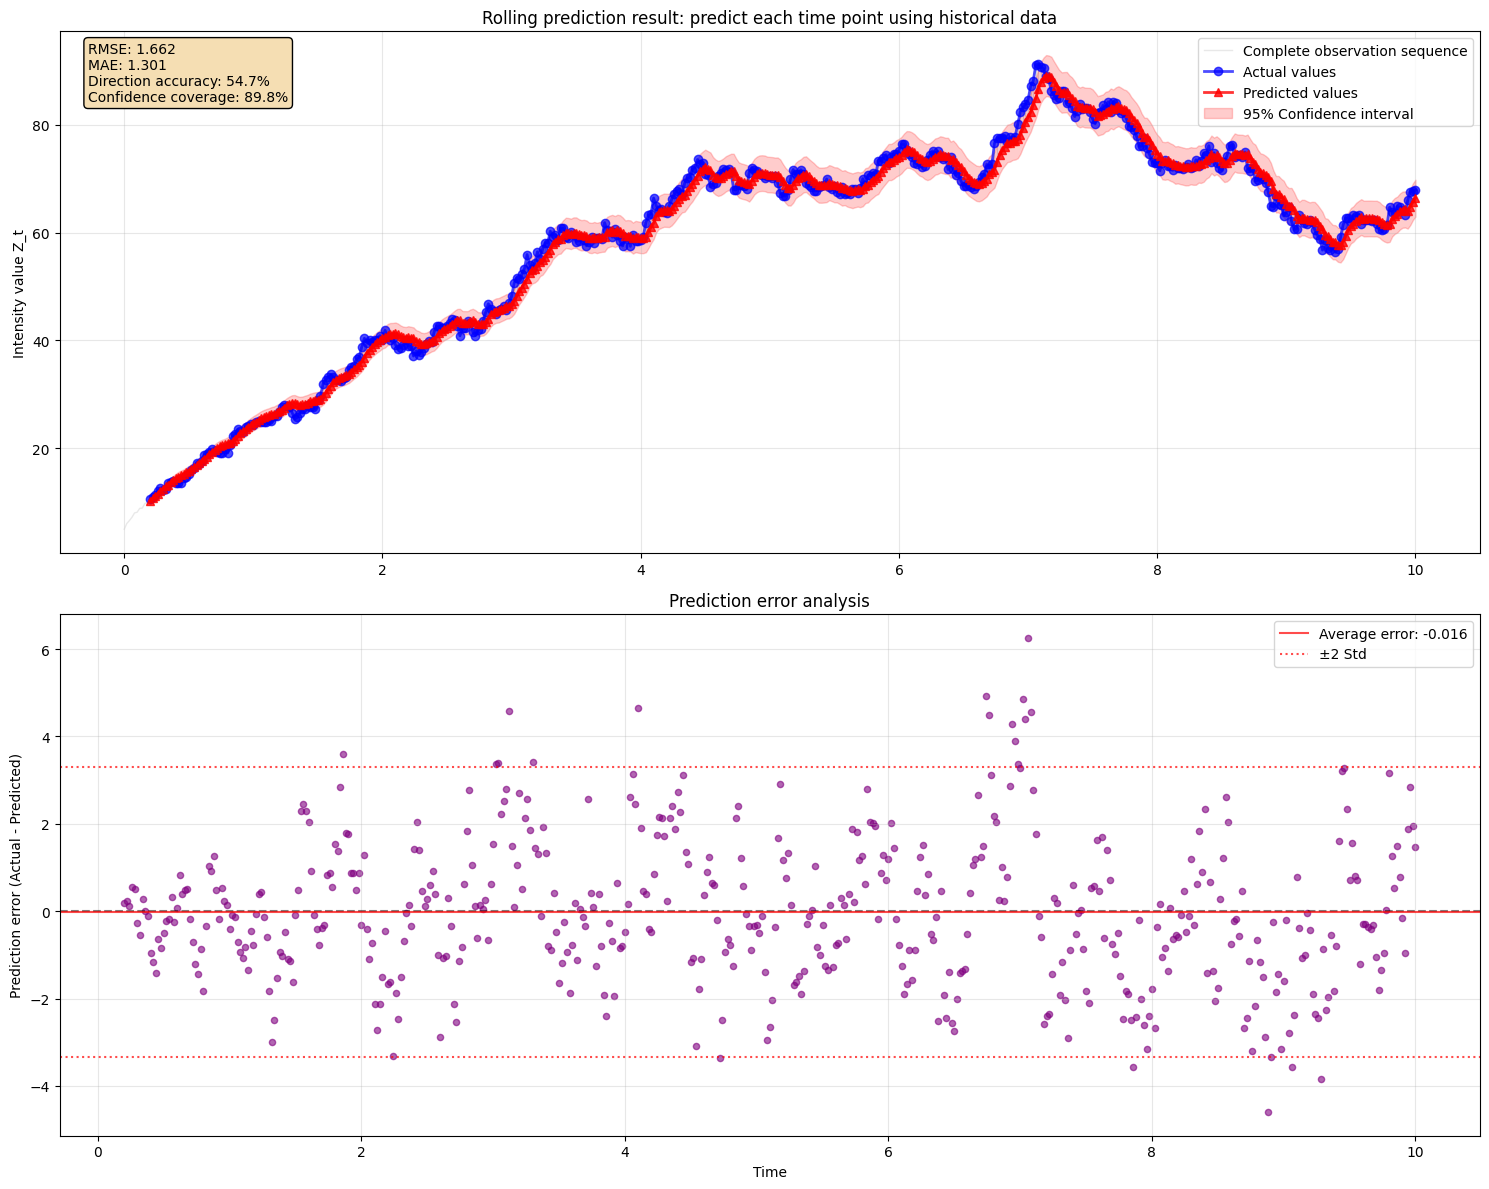


Usage:
result = rolling_kalman_predictor(data['time'], data['value'])
All prediction results in: result['detailed_results']

Printing PMF overlap:
✓ Loaded histogram: for_histogram_CoxM1_Z05_serv10_t5.pickle
  Total count: 1.444444444444439
  Probability sum: 1.000000
  Histogram range: [0.000000, 0.025004]
  Bins range: [0, 260]
✓ Plotted PMF for window size 10
  PMF sum: 1.000000
  Plotted PMF sum: 1.000000
  PMF range: [0.000000, 0.024952]
  PMF length: 351, Plotted length: 340


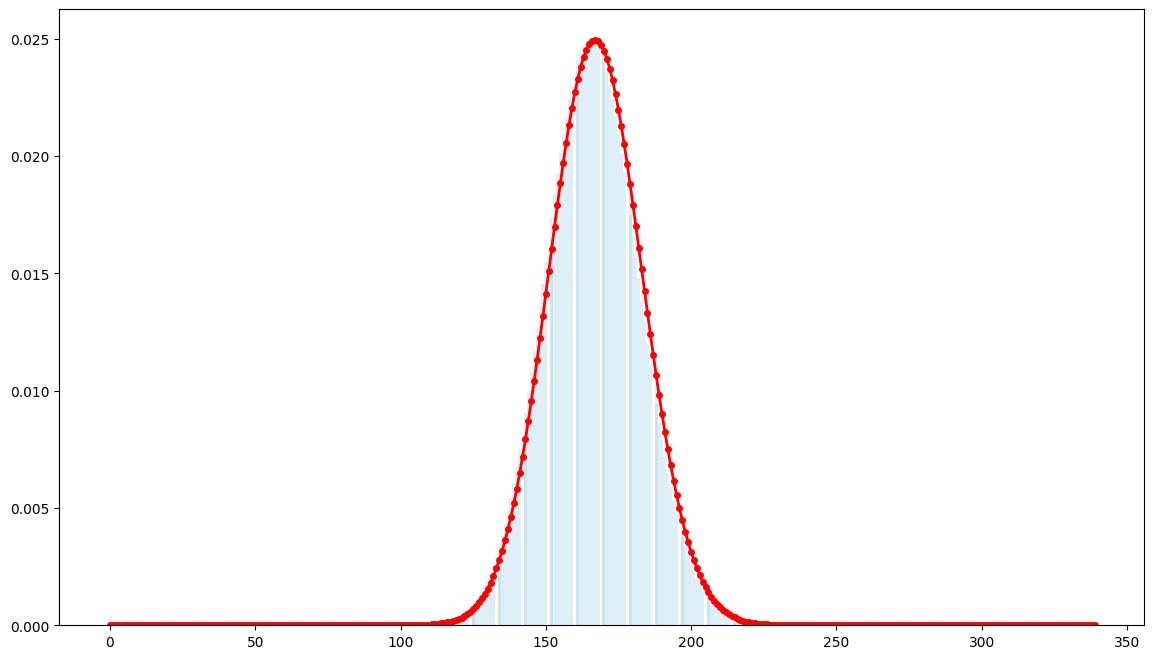

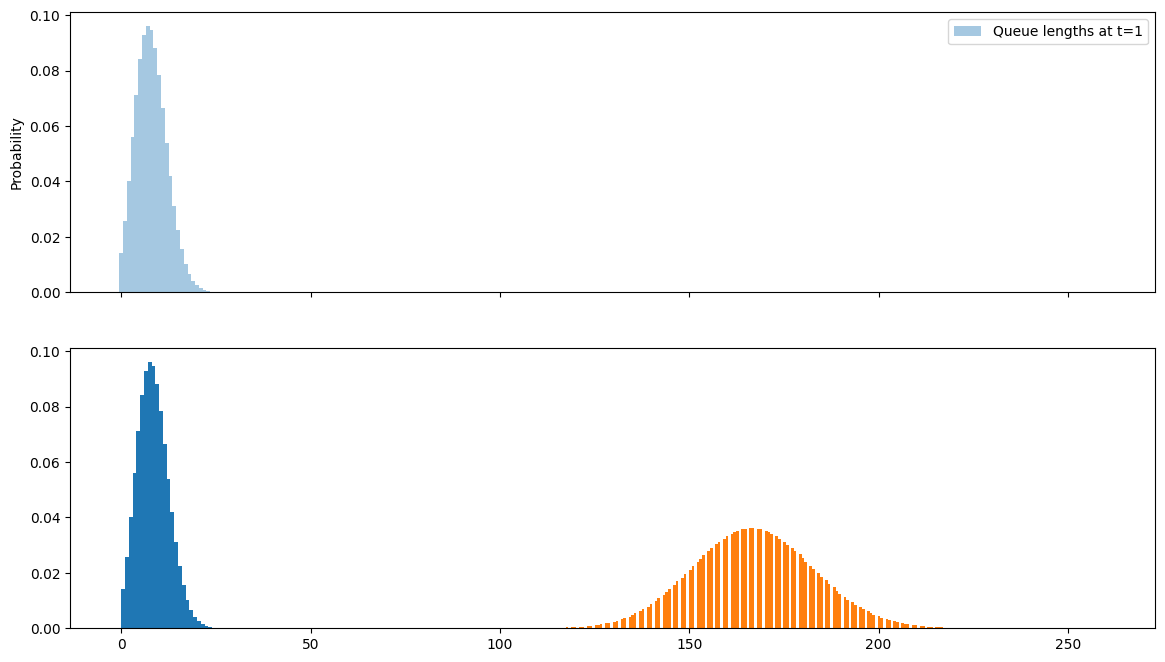

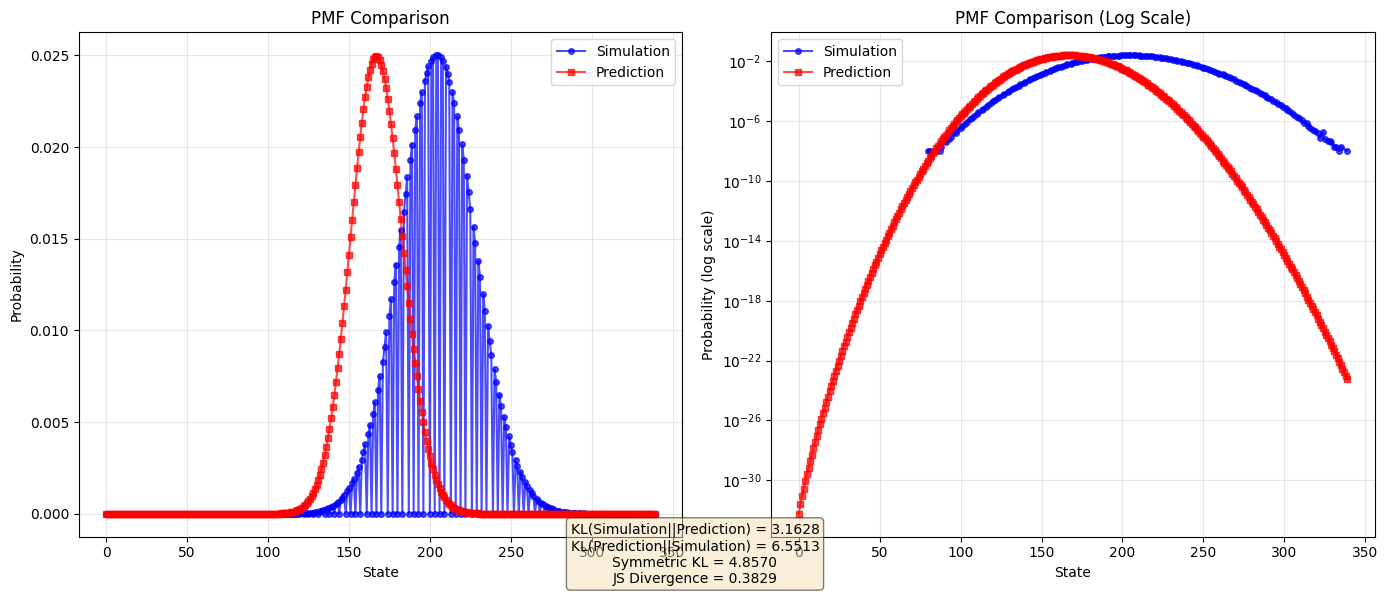

<Figure size 640x480 with 0 Axes>

✅ PMF overlap plot saved to /home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/pmf_data/M=500/initial_value_5_samples_500_predicted_kalman_pmf_min_hist_length_10/pmf_overlap_t5.png
--------------------------------------------------


In [ ]:
if __name__ == "__main__":
    np.random.seed(42)
    z_initial=5
    min_history_length=10
    method='kalman'
    values = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['value']
    times = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['time']
    
    print("Predictor")
 
    # Execute rolling prediction

    result = rolling_predictor(times, values, min_history_length=min_history_length, verbose=True,method=method)
    file_path_prediction = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/result_data/initial_value_{z_initial}_samples_500_predicted_{method}_min_history_length_{min_history_length}.csv'
    pd.DataFrame(result).to_csv(file_path_prediction)
    
    print(f"\nUsage:")
    print(f"result = rolling_kalman_predictor(data['time'], data['value'])")
    print(f"All prediction results in: result['detailed_results']")
    
    print('\nPrinting PMF overlap:')
    file_path_pmf = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/pmf_data/M=500/initial_value_{z_initial}_samples_500_predicted_{method}_pmf_min_hist_length_{min_history_length}/'   


    plot_pmf_overlap(
        [min_history_length],
        t=5,
        file_path=file_path_prediction,   
        save_path=file_path_pmf,
        Z_piece=result['detailed_results']['predicted_step_function'],
        dt_piece=result['detailed_results']['predicted_step_function_time_interval'],
        mu=10 if z_initial == 5 else 100 if z_initial == 80 else 100,
        m=1,
        z_initial=z_initial,
        hist_data_path='/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/Simulation_histograms',
        N=350, # max number of states
        show_histogram=True
    )